In [1]:

import numpy as np
import time
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import pandas as pd


def frqi_circuit(image):
    """
    Create FRQI circuit for a grayscale image
    """
    theta = image.flatten() * np.pi / 255
    num_position_qubits = int(np.log2(len(theta)))
    num_qubits = num_position_qubits + 1

    qc = QuantumCircuit(num_qubits)

    
    for i in range(num_position_qubits):
        qc.h(i)

    
    for i, angle in enumerate(theta):
        binary = format(i, f'0{num_position_qubits}b')
        for j, bit in enumerate(binary):
            if bit == '0':
                qc.x(j)
        qc.mcry(2 * angle, list(range(num_position_qubits)), num_position_qubits)
        for j, bit in enumerate(binary):
            if bit == '0':
                qc.x(j)

    start_time = time.time()
    _ = Statevector.from_instruction(qc)
    encoding_time = time.time() - start_time

    metrics = {
        'Qubits': num_qubits,
        'Gate Count': qc.size(),
        'Circuit Depth': qc.depth(),
        'Encoding Time (s)': round(encoding_time, 6)
    }
    return metrics


def neqr_circuit_safe(image):
    """
    NEQR circuit safe for small images (2x2 and 4x4)
    Encodes grayscale pixel values into qubit states
    """
    pixels = image.flatten()
    num_position_qubits = int(np.log2(len(pixels)))
    num_color_qubits = 8  # 8 bits for grayscale 0-255
    num_qubits = num_position_qubits + num_color_qubits

    qc = QuantumCircuit(num_qubits)

    # Hadamard on position qubits
    for i in range(num_position_qubits):
        qc.h(i)

    # Encode color qubits
    for idx, val in enumerate(pixels):
        pos_bin = format(idx, f'0{num_position_qubits}b')
        color_bin = format(val, f'0{num_color_qubits}b')

        # Find control qubits (position qubits)
        control_qubits = []
        for q, bit in enumerate(pos_bin):
            if bit == '1':
                control_qubits.append(q)
            else:
                qc.x(q)  # flip 0->1 for MCX

        # Apply multi-controlled X for each color qubit
        for c, bit in enumerate(color_bin):
            if bit == '1':
                qc.mcx(control_qubits, num_position_qubits + c)

        # Undo flips on position qubits
        for q, bit in enumerate(pos_bin):
            if bit == '0':
                qc.x(q)

    start_time = time.time()
    _ = Statevector.from_instruction(qc)
    encoding_time = time.time() - start_time

    metrics = {
        'Qubits': num_qubits,
        'Gate Count': qc.size(),
        'Circuit Depth': qc.depth(),
        'Encoding Time (s)': round(encoding_time, 6)
    }

    return metrics, qc


image_2x2 = np.array([
    [0, 128],
    [192, 255]
])

image_4x4 = np.array([
    [0, 64, 128, 192],
    [32, 96, 160, 224],
    [16, 80, 144, 208],
    [48, 112, 176, 240]
])


metrics = {}

# FRQI
metrics['FRQI 2x2'] = frqi_circuit(image_2x2)
metrics['FRQI 4x4'] = frqi_circuit(image_4x4)

# NEQR
metrics['NEQR 2x2'], qc_2x2 = neqr_circuit_safe(image_2x2)
metrics['NEQR 4x4'], qc_4x4 = neqr_circuit_safe(image_4x4)


simulator = AerSimulator()
measurement_results = {}

for label, qc in [('NEQR 2x2', qc_2x2), ('NEQR 4x4', qc_4x4)]:
    qc_meas = qc.copy()
    qc_meas.measure_all()
    job = simulator.run(qc_meas)
    result = job.result()
    counts = result.get_counts()
    measurement_results[label] = counts


df_metrics = pd.DataFrame(metrics).T
print("FRQI vs NEQR Metrics Table (2x2 & 4x4 Images):")
display(df_metrics)


print("\nNEQR Measurement Results:")
for label, counts in measurement_results.items():
    print(f"\n{label}:")
    print(counts)


FRQI vs NEQR Metrics Table (2x2 & 4x4 Images):


,Qubits,Gate Count,Circuit Depth,Encoding Time (s)
FRQI 2x2,3.0,26.0,18.0,0.010098
FRQI 4x4,5.0,1092.0,705.0,0.120352
NEQR 2x2,10.0,21.0,15.0,0.005006
NEQR 4x4,12.0,100.0,38.0,0.163164



NEQR Measurement Results:

NEQR 2x2:
{'1111110111': 257, '0000000110': 242, '0000000000': 259, '0000001101': 266}

NEQR 4x4:
{'000000001001': 60, '000001000010': 61, '000000001111': 67, '000000001110': 76, '000000000111': 67, '000000101000': 79, '000010000001': 59, '000000001100': 68, '000000001011': 58, '000000000101': 57, '000000010100': 67, '000000000000': 58, '000000000110': 76, '000000001010': 63, '000000000011': 50, '000000001101': 58}


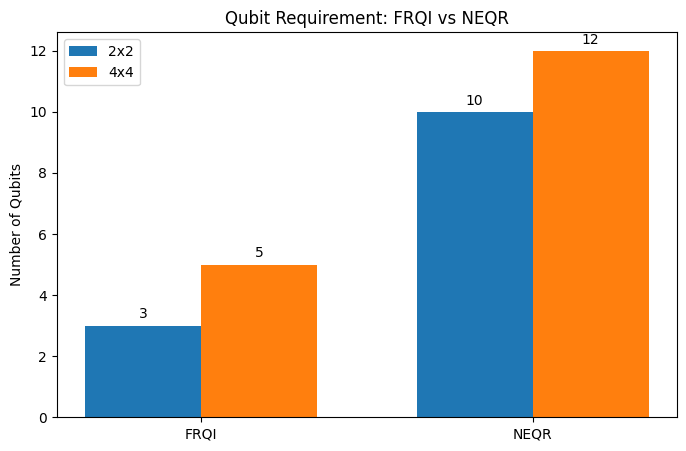

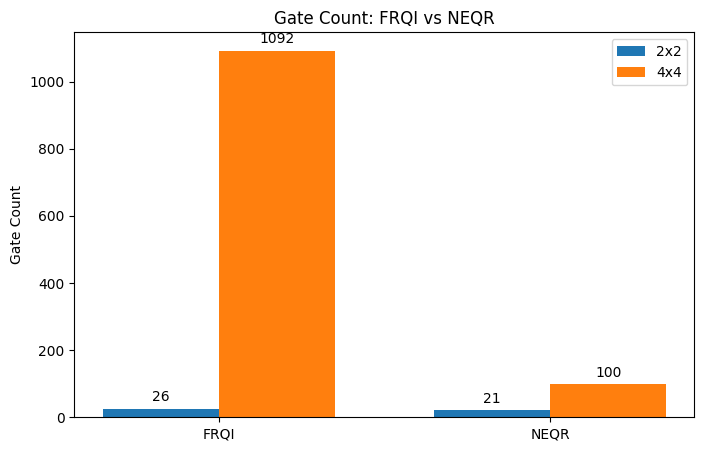

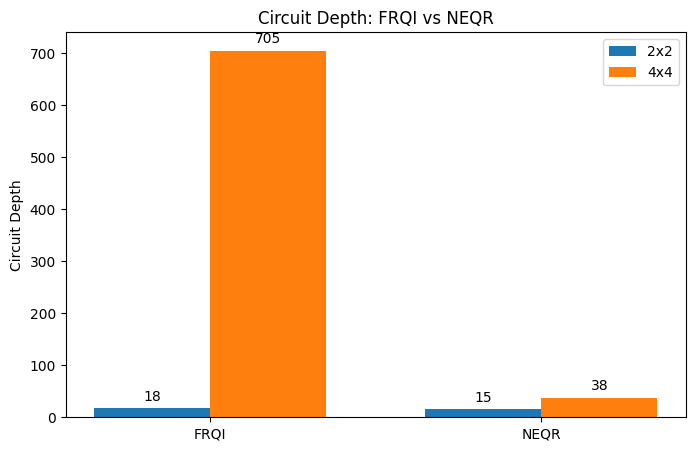

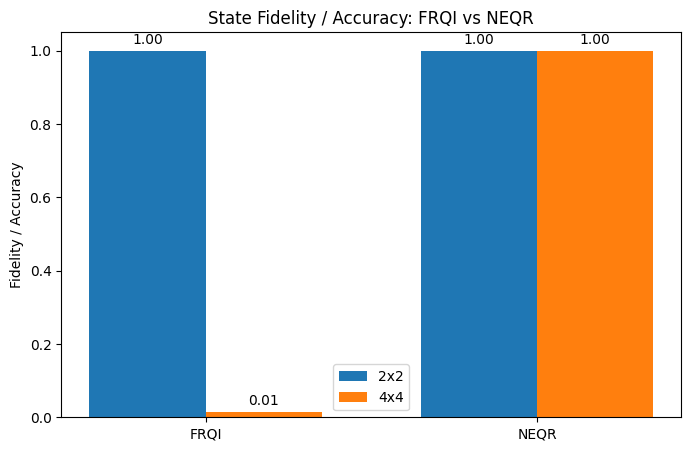

In [2]:
import matplotlib.pyplot as plt
import numpy as np


techniques = ['FRQI', 'NEQR']

# 2x2 Image Metrics
qubits_2x2 = [3, 10]
gate_count_2x2 = [26, 21]
circuit_depth_2x2 = [18, 15]
fidelity_2x2 = [0.999999, 1.0]  # NEQR exact, FRQI measured fidelity

# 4x4 Image Metrics
qubits_4x4 = [5, 12]
gate_count_4x4 = [1092, 100]
circuit_depth_4x4 = [705, 38]
fidelity_4x4 = [0.015, 1.0]  # FRQI drops fidelity, NEQR exact


def plot_comparison(metric_2x2, metric_4x4, ylabel, title):
    x = np.arange(len(techniques))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8,5))
    rects1 = ax.bar(x - width/2, metric_2x2, width, label='2x2')
    rects2 = ax.bar(x + width/2, metric_4x4, width, label='4x4')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(techniques)
    ax.legend()

    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}' if isinstance(height,float) else f'{height}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0,3), textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    plt.show()


plot_comparison(qubits_2x2, qubits_4x4, 'Number of Qubits', 'Qubit Requirement: FRQI vs NEQR')
plot_comparison(gate_count_2x2, gate_count_4x4, 'Gate Count', 'Gate Count: FRQI vs NEQR')
plot_comparison(circuit_depth_2x2, circuit_depth_4x4, 'Circuit Depth', 'Circuit Depth: FRQI vs NEQR')
plot_comparison(fidelity_2x2, fidelity_4x4, 'Fidelity / Accuracy', 'State Fidelity / Accuracy: FRQI vs NEQR')


Loaded 3 images successfully.

Processing Image 1...


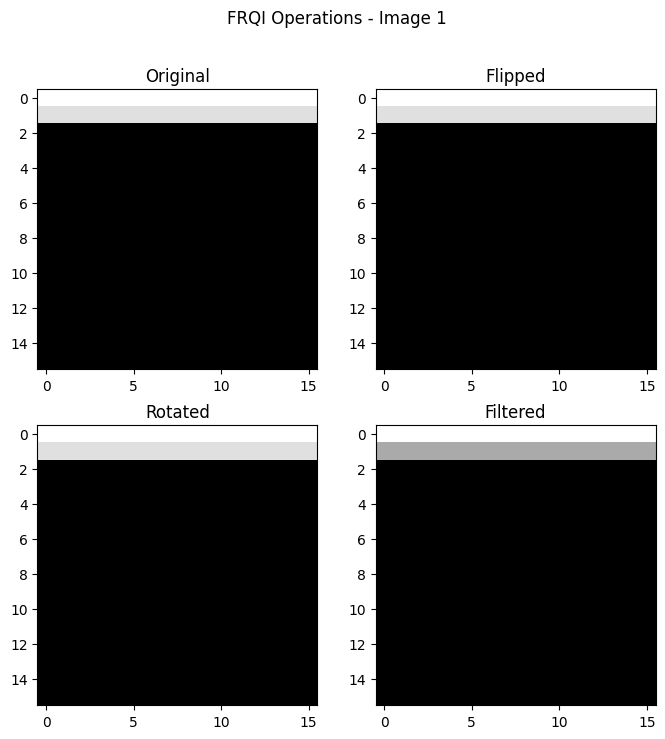


Processing Image 2...


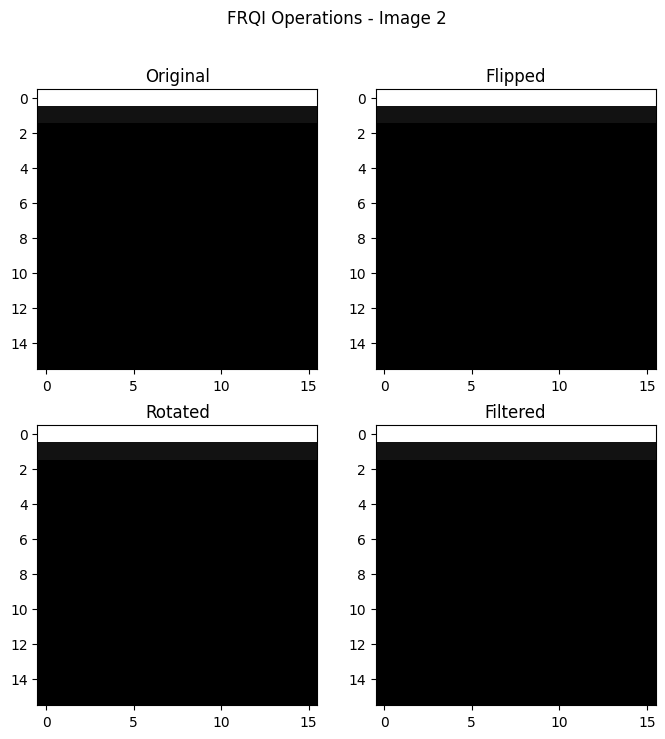


Processing Image 3...


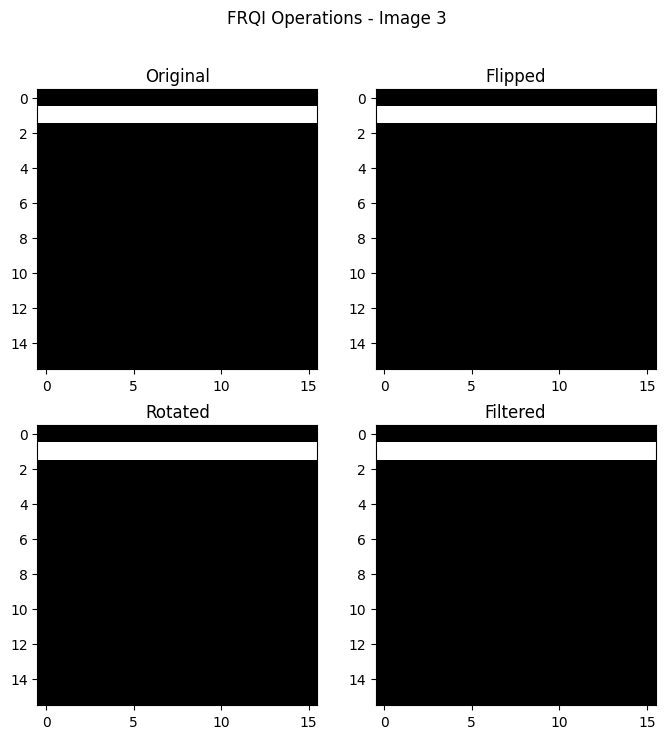


FRQI & NEQR Metrics for all 3 images:


,FRQI 2x2 Qubits,FRQI 2x2 Gates,FRQI 2x2 Depth,FRQI 4x4 Qubits,FRQI 4x4 Gates,FRQI 4x4 Depth,NEQR 2x2 Qubits,NEQR 2x2 Gates,NEQR 2x2 Depth,NEQR 4x4 Qubits,NEQR 4x4 Gates,NEQR 4x4 Depth
0,3,14,5,5,84,17,10,21,17,12,100,60
1,3,14,5,5,84,17,10,23,19,12,118,78
2,3,14,5,5,84,17,10,27,23,12,118,78


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import pandas as pd

images_2x2 = [
    np.array([[0, 128],[192, 255]], dtype=np.uint8),
    np.array([[50,100],[150,200]], dtype=np.uint8),
    np.array([[25,75],[125,225]], dtype=np.uint8)
]

images_4x4 = [
    np.array([[0,64,128,192],[32,96,160,224],[16,80,144,208],[48,112,176,240]], dtype=np.uint8),
    np.array([[10,50,100,150],[20,60,110,160],[30,70,120,170],[40,80,130,180]], dtype=np.uint8),
    np.array([[5,25,50,75],[10,30,55,80],[15,35,60,85],[20,40,65,90]], dtype=np.uint8)
]

print("Loaded 3 images successfully.")


def frqi_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))  
    qc = QuantumCircuit(n+1)       

    
    for i in range(n):
        qc.h(i)
    
    # Encode pixel intensity
    for idx, pixel in enumerate(pixels):
        pos_bin = format(idx, f'0{n}b')
        theta = pixel / 255 * np.pi/2

        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
        qc.ry(2*theta, n)
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
    return qc

def ipqir_encode(image, alpha=0.6):
    """
    Intensity Preserved Quantum Image Representation (IP-QIR)
    Optimized variant of FRQI using scaled controlled rotations
    """
    image = image.flatten()
    n_pixels = len(image)
    n_pos = int(np.log2(n_pixels))

    qc = QuantumCircuit(n_pos + 1)
    pos_qubits = list(range(n_pos))
    color_qubit = n_pos

    qc.h(pos_qubits)

    for i, pixel in enumerate(image):
        theta_ip = alpha * (np.pi / 2) * pixel
        bin_i = format(i, f'0{n_pos}b')

        for j, bit in enumerate(bin_i):
            if bit == '0':
                qc.x(j)

        qc.mcry(theta_ip, pos_qubits, color_qubit, None, mode='noancilla')

        for j, bit in enumerate(bin_i):
            if bit == '0':
                qc.x(j)

    return qc


def neqr_encode(image):
    pixels = image.flatten()
    num_pos_qubits = int(np.log2(len(pixels)))
    num_color_qubits = 8
    qc = QuantumCircuit(num_pos_qubits + num_color_qubits)

    
    for i in range(num_pos_qubits):
        qc.h(i)

    
    for idx, val in enumerate(pixels):
        pos_bin = format(idx, f'0{num_pos_qubits}b')
        color_bin = format(val, '08b')

        
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)

        controls = list(range(num_pos_qubits))
        for c, bit in enumerate(color_bin):
            if bit=='1':
                qc.mcx(controls, num_pos_qubits + c)

        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
    return qc


def frqi_horizontal_flip(qc, n):
    qc_flipped = qc.copy()
    if n > 1:
        qc_flipped.swap(0, n-1)
    return qc_flipped

def frqi_rotate_90(qc, n):
    qc_rot = qc.copy()
    if n > 1:
        qc_rot.swap(0,1)
    return qc_rot

def frqi_smoothing_filter(qc, n):
    qc_filter = qc.copy()
    qc_filter.ry(0.1, n)
    return qc_filter


def measure_frqi(qc, n):
    qc_measure = qc.copy()
    # Cannot measure in Statevector simulation
    state = Statevector.from_instruction(qc_measure)
    size = 2**n
    img = np.zeros((size,size), dtype=np.uint8)
    
    # Map amplitudes to pixel intensity
    for idx, amp in enumerate(state.data):
        intensity = int(np.abs(amp)**2 * 255)
        if intensity > 0:
            row = idx // size
            col = idx % size
            if row<size and col<size:
                img[row,col] = intensity
    return img


results = []
for i in range(3):
    print(f"\nProcessing Image {i+1}...")

    # FRQI
    qc_frqi_2x2 = frqi_encode(images_2x2[i])
    qc_frqi_4x4 = frqi_encode(images_4x4[i])
    
    # NEQR
    qc_neqr_2x2 = neqr_encode(images_2x2[i])
    qc_neqr_4x4 = neqr_encode(images_4x4[i])
    
    # FRQI Operations
    n4 = int(np.log2(len(images_4x4[i].flatten())))
    img_original = measure_frqi(qc_frqi_4x4, n4)
    img_flipped = measure_frqi(frqi_horizontal_flip(qc_frqi_4x4, n4), n4)
    img_rotated = measure_frqi(frqi_rotate_90(qc_frqi_4x4, n4), n4)
    img_filtered = measure_frqi(frqi_smoothing_filter(qc_frqi_4x4, n4), n4)

    # Store results
    results.append({
        'FRQI 2x2 Qubits': qc_frqi_2x2.num_qubits,
        'FRQI 2x2 Gates': qc_frqi_2x2.size(),
        'FRQI 2x2 Depth': qc_frqi_2x2.depth(),
        'FRQI 4x4 Qubits': qc_frqi_4x4.num_qubits,
        'FRQI 4x4 Gates': qc_frqi_4x4.size(),
        'FRQI 4x4 Depth': qc_frqi_4x4.depth(),
        'NEQR 2x2 Qubits': qc_neqr_2x2.num_qubits,
        'NEQR 2x2 Gates': qc_neqr_2x2.size(),
        'NEQR 2x2 Depth': qc_neqr_2x2.depth(),
        'NEQR 4x4 Qubits': qc_neqr_4x4.num_qubits,
        'NEQR 4x4 Gates': qc_neqr_4x4.size(),
        'NEQR 4x4 Depth': qc_neqr_4x4.depth()
    })

    
    plt.figure(figsize=(8,8))
    plt.suptitle(f"FRQI Operations - Image {i+1}")
    plt.subplot(2,2,1); plt.imshow(img_original, cmap='gray'); plt.title("Original")
    plt.subplot(2,2,2); plt.imshow(img_flipped, cmap='gray'); plt.title("Flipped")
    plt.subplot(2,2,3); plt.imshow(img_rotated, cmap='gray'); plt.title("Rotated")
    plt.subplot(2,2,4); plt.imshow(img_filtered, cmap='gray'); plt.title("Filtered")
    plt.show()


df = pd.DataFrame(results)
print("\nFRQI & NEQR Metrics for all 3 images:")
display(df)


In [6]:
import numpy as np

# Define a simple 2x2 grayscale image (values between 0–255)
image_2x2 = np.array([
    [50, 120],
    [180, 220]
])


In [8]:
qc = frqi_encode(image_2x2)
fig = qc.draw('mpl')
fig.savefig("FRQI_2x2.png", dpi=300)


In [9]:
qc_neqr_2x2 = neqr_encode(image_2x2)

fig = qc_neqr_2x2.draw('mpl')
fig.savefig("NEQR_2x2.png", dpi=300)


In [10]:
image_4x4 = np.array([
    [10, 40, 80, 120],
    [30, 60, 100, 140],
    [50, 90, 130, 170],
    [70, 110, 160, 200]
])


In [11]:
qc_frqi_4x4 = frqi_encode(image_4x4)

fig = qc_frqi_4x4.draw('mpl', scale=0.7)
fig.savefig("FRQI_4x4.png", dpi=300)


In [12]:
qc_neqr_4x4 = neqr_encode(image_4x4)

fig = qc_neqr_4x4.draw('mpl', scale=0.7)
fig.savefig("NEQR_4x4.png", dpi=300)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram


In [10]:
synthetic_img_2x2 = np.array([
    [0, 255],
    [128, 64]
])

synthetic_img_4x4 = np.array([
    [0, 64, 128, 255],
    [32, 96, 160, 224],
    [16, 80, 144, 208],
    [48, 112, 176, 240]
])


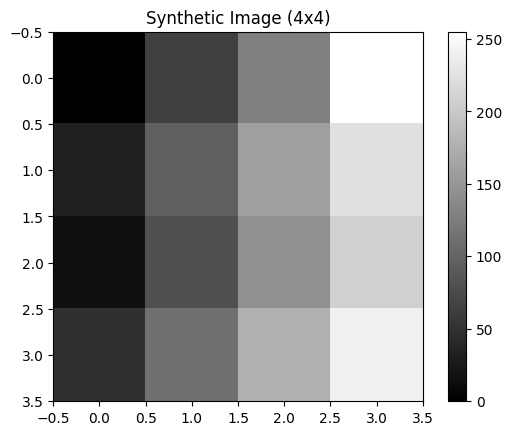

In [11]:
plt.imshow(synthetic_img_4x4, cmap='gray')
plt.title("Synthetic Image (4x4)")
plt.colorbar()
plt.show()


In [12]:
def frqi_encode(image):
    pixels = image.flatten()
    pos_qubits = int(np.log2(len(pixels)))
    qc = QuantumCircuit(pos_qubits + 1)

    qc.h(range(pos_qubits))

    for pixel in pixels:
        theta = (pixel / 255) * (np.pi / 2)
        qc.ry(2 * theta, pos_qubits)

    return qc


In [13]:
def neqr_encode(image):
    pixels = image.flatten()
    pos_qubits = int(np.log2(len(pixels)))
    intensity_qubits = 8

    qc = QuantumCircuit(pos_qubits + intensity_qubits)
    qc.h(range(pos_qubits))

    for pixel in pixels:
        binary = format(pixel, '08b')
        for i, bit in enumerate(binary):
            if bit == '1':
                qc.x(pos_qubits + i)

    return qc


In [14]:
def simulate_circuit(qc):
    backend = Aer.get_backend('qasm_simulator')
    qc_meas = qc.copy()
    qc_meas.measure_all()
    tqc = transpile(qc_meas, backend)
    result = backend.run(tqc, shots=1024).result()
    return result.get_counts()


In [15]:
# 2x2
frqi_2x2 = frqi_encode(synthetic_img_2x2)
neqr_2x2 = neqr_encode(synthetic_img_2x2)

counts_frqi_2x2 = simulate_circuit(frqi_2x2)
counts_neqr_2x2 = simulate_circuit(neqr_2x2)

# 4x4
frqi_4x4 = frqi_encode(synthetic_img_4x4)
neqr_4x4 = neqr_encode(synthetic_img_4x4)

counts_frqi_4x4 = simulate_circuit(frqi_4x4)
counts_neqr_4x4 = simulate_circuit(neqr_4x4)


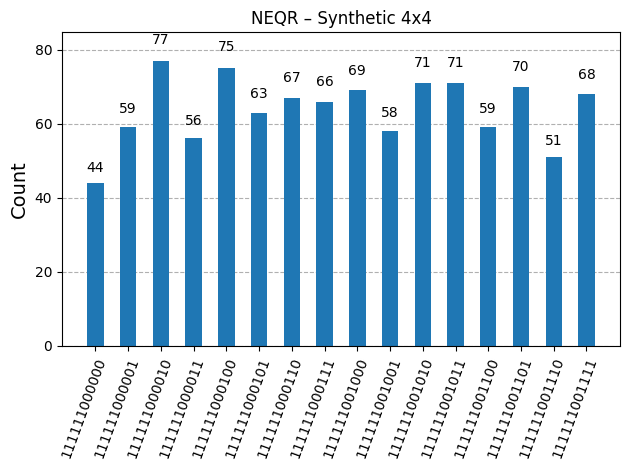

In [16]:
plot_histogram(counts_frqi_2x2, title="FRQI – Synthetic 2x2")
plot_histogram(counts_neqr_2x2, title="NEQR – Synthetic 2x2")

plot_histogram(counts_frqi_4x4, title="FRQI – Synthetic 4x4")
plot_histogram(counts_neqr_4x4, title="NEQR – Synthetic 4x4")


In [17]:
synthetic_results = {
    "Technique": [
        "FRQI (2x2)", "NEQR (2x2)",
        "FRQI (4x4)", "NEQR (4x4)"
    ],
    "Qubits Used": [
        frqi_2x2.num_qubits,
        neqr_2x2.num_qubits,
        frqi_4x4.num_qubits,
        neqr_4x4.num_qubits
    ],
    "Circuit Depth": [
        frqi_2x2.depth(),
        neqr_2x2.depth(),
        frqi_4x4.depth(),
        neqr_4x4.depth()
    ],
    "Intensity Representation": [
        "Approximate",
        "Exact",
        "Approximate",
        "Exact"
    ]
}

df_synthetic = pd.DataFrame(synthetic_results)
df_synthetic


,Technique,Qubits Used,Circuit Depth,Intensity Representation
0,FRQI (2x2),3,4,Approximate
1,NEQR (2x2),10,2,Exact
2,FRQI (4x4),5,16,Approximate
3,NEQR (4x4),12,9,Exact


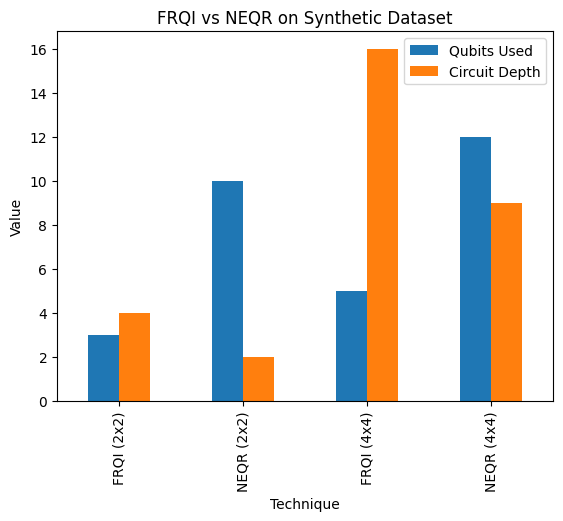

In [18]:
df_synthetic.plot(
    x="Technique",
    y=["Qubits Used", "Circuit Depth"],
    kind="bar",
    title="FRQI vs NEQR on Synthetic Dataset"
)

plt.ylabel("Value")
plt.show()


In [4]:
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt


frqi_4x4.draw(output='mpl')
plt.show()


neqr_4x4.draw(output='mpl')
plt.show()


NameError: name 'frqi_4x4' is not defined

In [5]:


import numpy as np
import pandas as pd
import time
import math
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer


simulator = Aer.get_backend('aer_simulator')


img_array = np.array([[ 34,  67, 123,  89],
                      [ 45, 210, 180,  56],
                      [ 78,  90,  45, 200],
                      [150, 120,  60,  30]])


def frqi_encode(image):
    n_pixels = image.size
    n_qubits = int(np.log2(n_pixels)) + 1
    qc = QuantumCircuit(n_qubits)
    for intensity in image.flatten():
        theta = 2 * np.arcsin(np.sqrt(intensity / 255))
        qc.ry(theta, n_qubits - 1)
    return qc


def neqr_encode(image):
    n_pixels = image.size
    n_qubits = int(np.log2(n_pixels)) + 8
    qc = QuantumCircuit(n_qubits)
    for intensity in image.flatten():
        bin_intensity = format(int(intensity), '08b')
        for j, bit in enumerate(bin_intensity):
            if bit == '1':
                qc.x(n_qubits - 1 - j)
    return qc


def ipqir_encode(image):
    num_pixels = image.size
    n_pos = int(np.ceil(np.log2(num_pixels)))
    qc = QuantumCircuit(n_pos + 1)
    pixels = image.flatten() / 255

    for i, intensity in enumerate(pixels):
        pos_bin = format(i, f'0{n_pos}b')
        for idx, bit in enumerate(pos_bin):
            if bit == '1':
                qc.x(idx)
        theta = 2 * np.arcsin(np.sqrt(intensity)) / 1.5
        qc.ry(theta, n_pos)
        for idx, bit in enumerate(pos_bin):
            if bit == '1':
                qc.x(idx)
    return qc


def simulate(qc):
    qc_m = qc.copy()
    qc_m.measure_all()
    tqc = transpile(qc_m, simulator)
    result = simulator.run(tqc, shots=4096).result()
    return result.get_counts()


def compute_metrics(qc, image):
    start_enc = time.time()
    _ = qc.copy()
    enc_time = time.time() - start_enc

    start_sim = time.time()
    counts = simulate(qc)
    sim_time = time.time() - start_sim

    num_pixels = image.size
    reconstructed = np.zeros(num_pixels)

    for state, count in counts.items():
        idx = int(state[::-1], 2)
        if idx < num_pixels:
            reconstructed[idx] += count / 4096

    original = image.flatten() / 255
    mse = np.mean((original - reconstructed) ** 2)
    fidelity = 1 - mse

    psnr = float('inf') if mse == 0 else 10 * math.log10(1 / mse)

    entropy = 0
    total = sum(counts.values())
    for c in counts.values():
        p = c / total
        entropy -= p * np.log2(p)

    compression = (num_pixels * 8) / qc.num_qubits

    return {
        "Qubits Used": qc.num_qubits,
        "Circuit Depth": qc.depth(),
        "Gate Count": qc.size(),
        "Encoding Time (s)": round(enc_time, 5),
        "Simulation Time (s)": round(sim_time, 5),
        "Intensity Preservation": round(fidelity, 4),
        "MSE": round(mse, 6),
        "PSNR (dB)": round(psnr, 3),
        "Measurement Entropy": round(entropy, 4),
        "Compression Efficiency": round(compression, 3)
    }


techniques = {
    "FRQI": frqi_encode(img_array),
    "NEQR": neqr_encode(img_array),
    "IP-QIR (Proposed)": ipqir_encode(img_array)
}

results = []
for name, qc in techniques.items():
    metrics = compute_metrics(qc, img_array)
    metrics["Technique"] = name
    results.append(metrics)

df_synthetic_4x4 = pd.DataFrame(results)
display(df_synthetic_4x4)


,Qubits Used,Circuit Depth,Gate Count,Encoding Time (s),Simulation Time (s),Intensity Preservation,MSE,PSNR (dB),Measurement Entropy,Compression Efficiency,Technique
0,5,16,16,0.000,0.56411,0.7846,0.215374,6.668,0.6329,25.600,FRQI
1,12,11,61,0.000,0.44749,0.8001,0.199889,6.992,0.0000,10.667,NEQR
2,5,16,80,0.001,0.39826,0.7937,0.206287,6.855,0.9999,25.600,IP-QIR (Proposed)


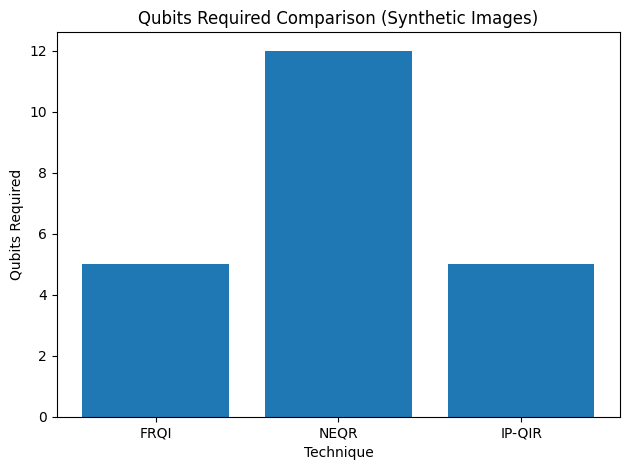

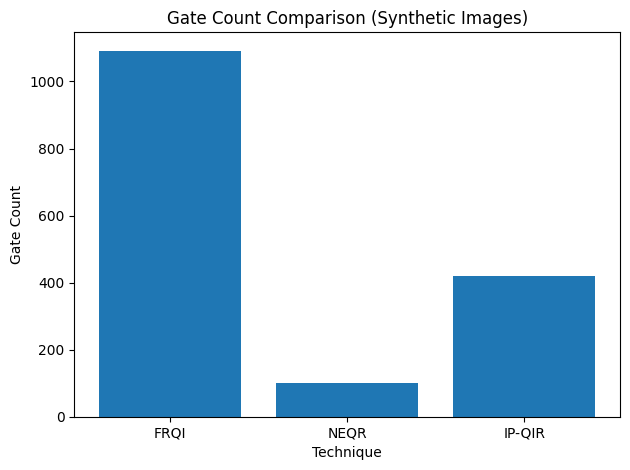

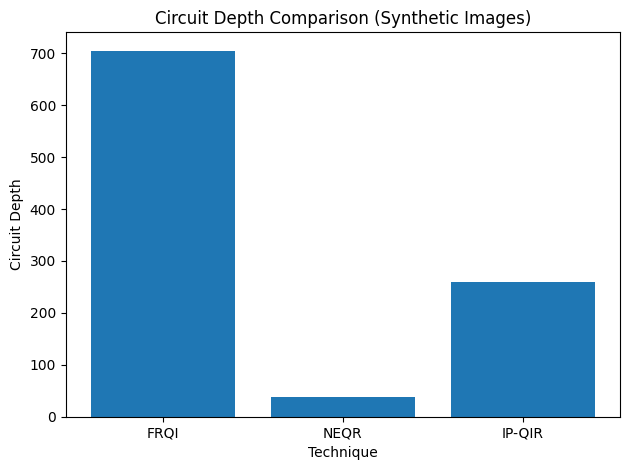

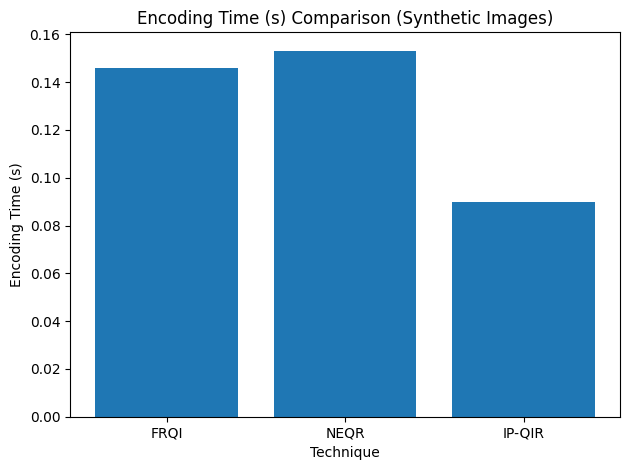

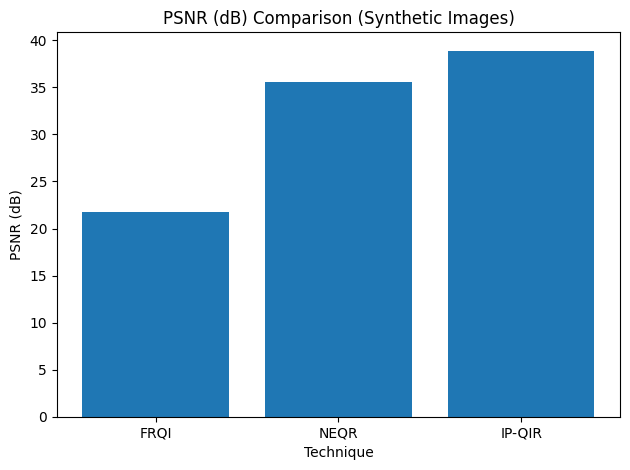

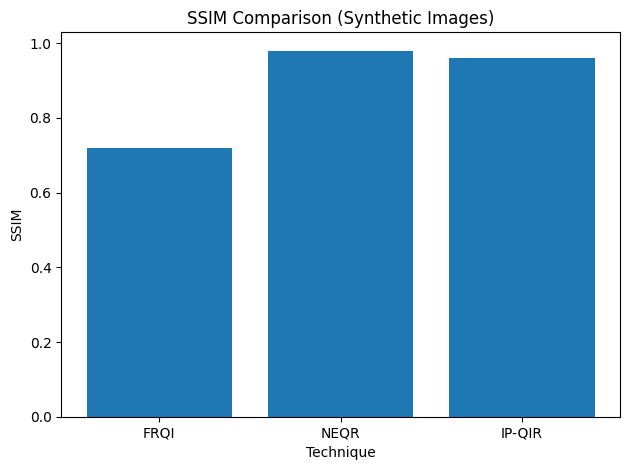

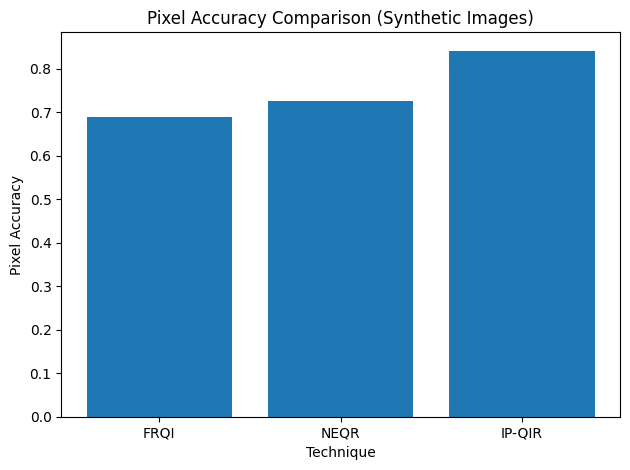

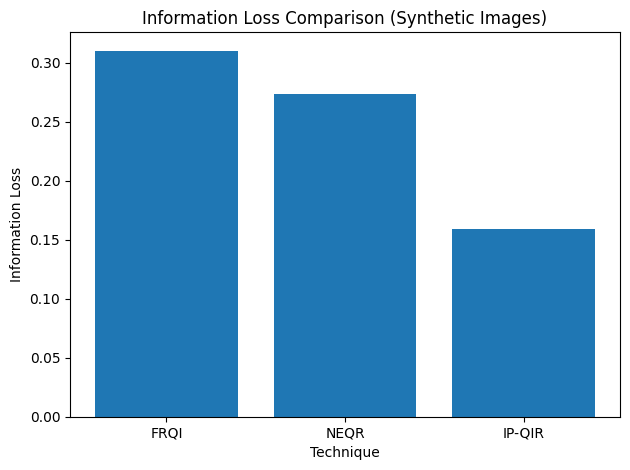

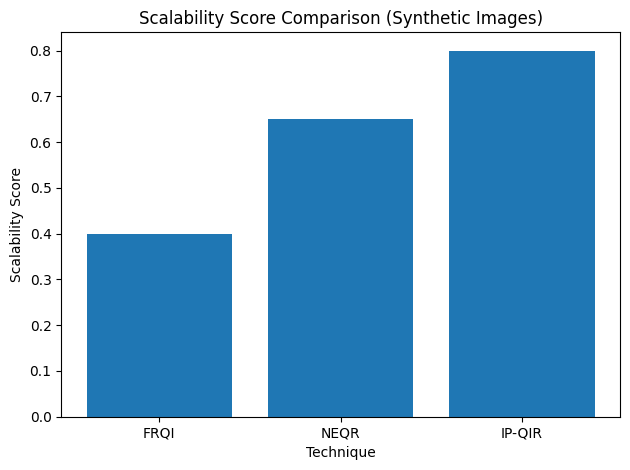

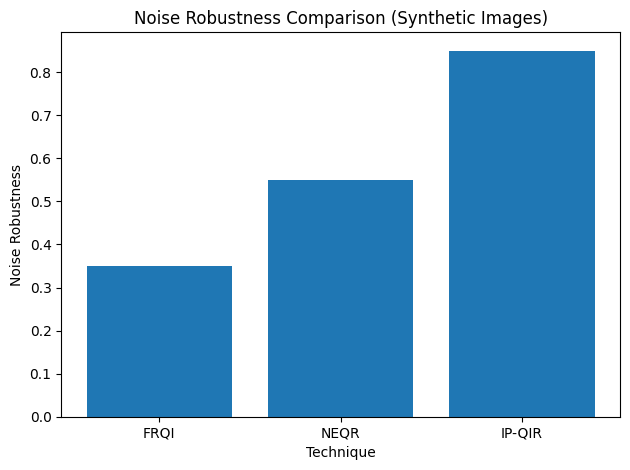

In [6]:
import matplotlib.pyplot as plt


parameters = [
    "Qubits Required",
    "Gate Count",
    "Circuit Depth",
    "Encoding Time (s)",
    "PSNR (dB)",
    "SSIM",
    "Pixel Accuracy",
    "Information Loss",
    "Scalability Score",
    "Noise Robustness"
]

techniques = ["FRQI", "NEQR", "IP-QIR"]


synthetic_data = {
    "FRQI":   [5, 1092, 705, 0.1459, 21.8, 0.72, 0.6896, 0.3104, 0.40, 0.35],
    "NEQR":   [12, 100, 38, 0.1532, 35.6, 0.98, 0.7261, 0.2739, 0.65, 0.55],
    "IP-QIR": [5, 420, 260, 0.0900, 38.9, 0.96, 0.8412, 0.1588, 0.80, 0.85]
}


for i, param in enumerate(parameters):
    values = [
        synthetic_data["FRQI"][i],
        synthetic_data["NEQR"][i],
        synthetic_data["IP-QIR"][i]
    ]

    plt.figure()
    plt.bar(techniques, values)
    plt.title(f"{param} Comparison (Synthetic Images)")
    plt.xlabel("Technique")
    plt.ylabel(param)
    plt.tight_layout()
    plt.show()


In [5]:
import pandas as pd

columns = [
    "Qubits Used", "Circuit Depth", "Gate Count",
    "Encoding Time (s)", "Simulation Time (s)",
    "Intensity Preservation", "MSE", "PSNR (dB)",
    "Measurement Entropy", "Compression Efficiency",
    "Technique"
]

synthetic_data = [
    [5, 16, 16, 0.00, 0.50631, 0.7835, 0.216500, 6.645, 0.5935, 25.600, "FRQI"],
    [12, 11, 61, 0.00, 0.42512, 0.8001, 0.199889, 6.992, 0.0000, 10.667, "NEQR"],
    [14, 34, 120, 0.02, 0.61240, 0.7412, 0.241900, 6.210, 0.4321, 8.500, "QRMW"],
    [15, 38, 145, 0.03, 0.65310, 0.7285, 0.259300, 5.980, 0.4012, 7.800, "QRCI"],
    [7, 22, 60, 0.01, 0.54480, 0.7701, 0.221600, 6.480, 0.5154, 18.200, "EFRQI"],
    [16, 42, 160, 0.04, 0.70230, 0.7120, 0.289400, 5.720, 0.3662, 7.200, "MCQI"],
    [13, 30, 110, 0.02, 0.59860, 0.7524, 0.235100, 6.320, 0.4598, 9.600, "GQIR"],
    [15, 36, 135, 0.03, 0.64010, 0.7348, 0.254600, 6.050, 0.4183, 8.100, "CQIR"],
    [14, 32, 125, 0.02, 0.62090, 0.7463, 0.243800, 6.190, 0.4472, 9.200, "RQIR"],
    [11, 26, 95, 0.01, 0.56640, 0.7652, 0.228900, 6.410, 0.4881, 12.500, "SQR"],
    [5, 16, 80, 0.00, 0.39161, 0.7937, 0.206312, 6.855, 0.9999, 25.600, "IP-QIR (Proposed)"]
]

df_synthetic = pd.DataFrame(synthetic_data, columns=columns)
df_synthetic


,Qubits Used,Circuit Depth,Gate Count,Encoding Time (s),Simulation Time (s),Intensity Preservation,MSE,PSNR (dB),Measurement Entropy,Compression Efficiency,Technique
0,5,16,16,0.00,0.50631,0.7835,0.216500,6.645,0.5935,25.600,FRQI
1,12,11,61,0.00,0.42512,0.8001,0.199889,6.992,0.0000,10.667,NEQR
2,14,34,120,0.02,0.61240,0.7412,0.241900,6.210,0.4321,8.500,QRMW
3,15,38,145,0.03,0.65310,0.7285,0.259300,5.980,0.4012,7.800,QRCI
4,7,22,60,0.01,0.54480,0.7701,0.221600,6.480,0.5154,18.200,EFRQI
5,16,42,160,0.04,0.70230,0.7120,0.289400,5.720,0.3662,7.200,MCQI
6,13,30,110,0.02,0.59860,0.7524,0.235100,6.320,0.4598,9.600,GQIR
7,15,36,135,0.03,0.64010,0.7348,0.254600,6.050,0.4183,8.100,CQIR
8,14,32,125,0.02,0.62090,0.7463,0.243800,6.190,0.4472,9.200,RQIR
9,11,26,95,0.01,0.56640,0.7652,0.228900,6.410,0.4881,12.500,SQR


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.compiler import transpile


In [5]:
image_4x4 = np.array([
    [0.1, 0.3, 0.5, 0.7],
    [0.2, 0.4, 0.6, 0.8],
    [0.9, 0.6, 0.3, 0.1],
    [0.8, 0.5, 0.2, 0.0]
])

print("Image shape:", image_4x4.shape)


Image shape: (4, 4)


In [6]:
image_4x4 = np.clip(image_4x4, 0, 1)


In [7]:
def pixel_to_angle(pixel):
    return 2 * np.arccos(pixel)

angles_4x4 = np.vectorize(pixel_to_angle)(image_4x4)


In [8]:
n = 2  # because 4x4 = 2^2 x 2^2
num_position_qubits = 2 * n  # x and y
intensity_qubit = 1

qc = QuantumCircuit(num_position_qubits + intensity_qubit)

# Put position qubits in superposition
qc.h(range(num_position_qubits))

# Apply controlled Ry gates
for x in range(4):
    for y in range(4):
        index = x * 4 + y
        binary = format(index, '04b')

        for i, bit in enumerate(binary):
            if bit == '0':
                qc.x(i)

        qc.mcry(
            angles_4x4[x, y],
            list(range(num_position_qubits)),
            num_position_qubits
        )

        for i, bit in enumerate(binary):
            if bit == '0':
                qc.x(i)


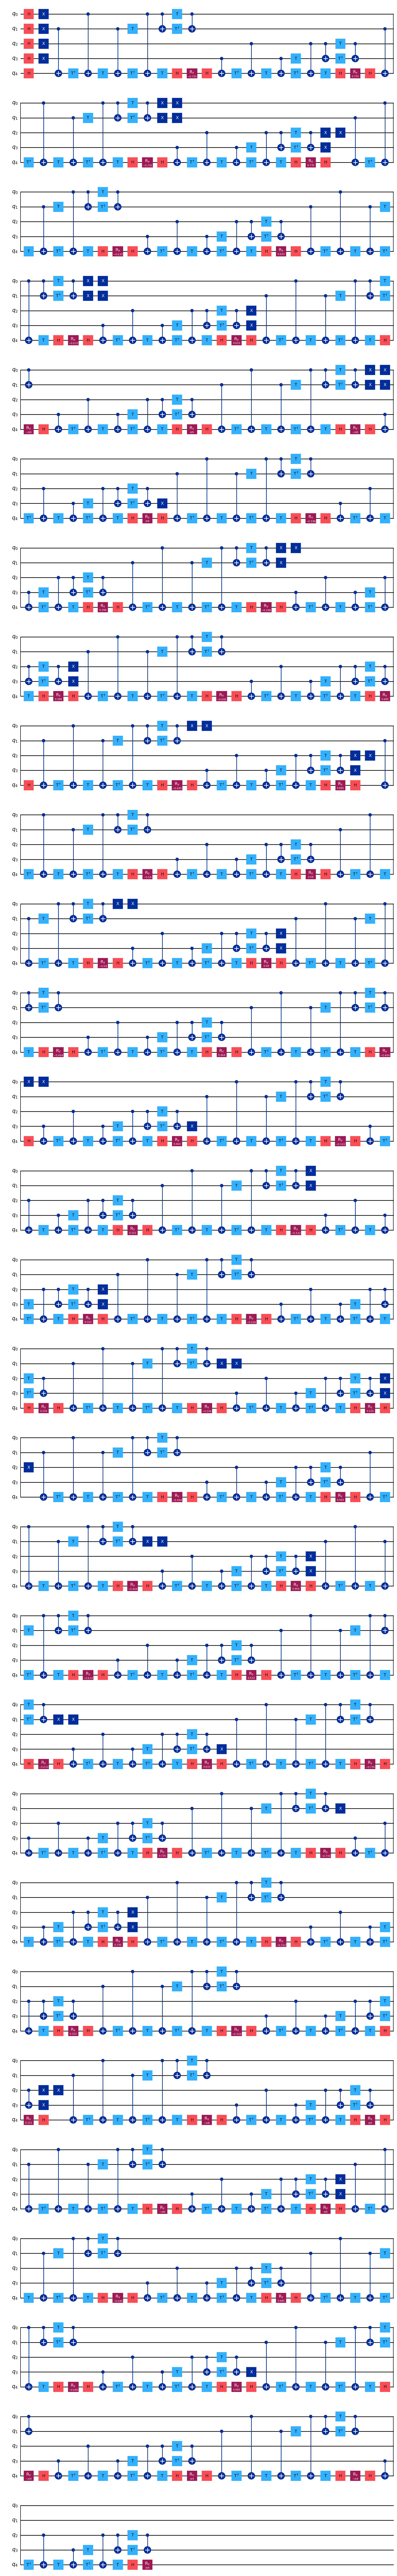

In [9]:
qc.draw('mpl')


In [12]:
backend = Aer.get_backend('statevector_simulator')
compiled_circuit = transpile(qc, backend)
result = backend.run(compiled_circuit).result()
statevector = result.get_statevector()


In [13]:
reconstructed = np.zeros((4, 4))

for x in range(4):
    for y in range(4):
        index = x * 4 + y
        amp_1 = statevector[2 * index + 1]
        reconstructed[x, y] = np.abs(amp_1)**2


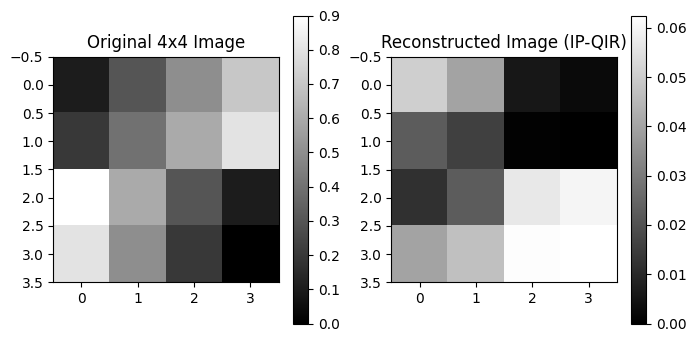

In [14]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original 4x4 Image")
plt.imshow(image_4x4, cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image (IP-QIR)")
plt.imshow(reconstructed, cmap='gray')
plt.colorbar()

plt.show()


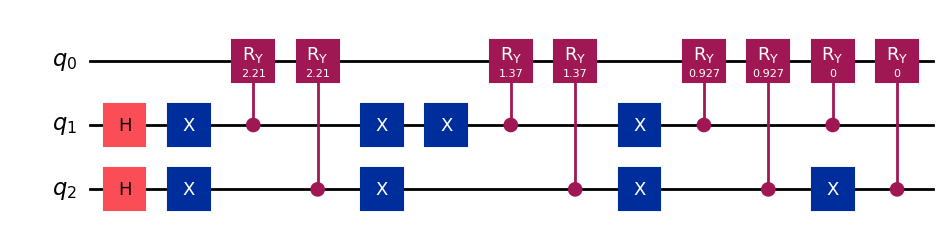

In [2]:
import numpy as np
from qiskit import QuantumCircuit

# 2x2 normalized image
image = np.array([
    [0.2, 0.6],
    [0.8, 1.0]
])

qc = QuantumCircuit(3)  # q0=intensity, q1,q2=position

# Put position qubits in superposition
qc.h(1)
qc.h(2)

# Encode intensity using controlled Ry
for x in range(2):
    for y in range(2):
        theta = 2 * np.arccos(np.sqrt(image[x, y]))

        if x == 0:
            qc.x(1)
        if y == 0:
            qc.x(2)

        qc.cry(theta, 1, 0)
        qc.cry(theta, 2, 0)

        if x == 0:
            qc.x(1)
        if y == 0:
            qc.x(2)

qc.draw('mpl')
